In [26]:
!pip install --upgrade langchain langchain-google-genai "langchain[docarray]" faiss-cpu pypdf

In [27]:
!pip install langchain_community

In [28]:
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Markdown
from langchain_google_genai import ChatGoogleGenerativeAI

In [29]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.vectorstores import DocArrayInMemorySearch
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [30]:
from langchain.schema.document import Document
from langchain_community.document_loaders import TextLoader

In [31]:
from langchain_text_splitters import CharacterTextSplitter

In [32]:
from langchain_community.vectorstores import FAISS

# Load the Google API Key

In [33]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"]= GOOGLE_API_KEY

# Load the Model

In [34]:
def load_model(model_name):
  if model_name=='gemini-1.5-flash-latest':
    llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash-latest')
  else:
    llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash-latest')
  return llm

In [35]:
model_text=load_model('gemini-pro')

In [36]:
response=model_text.invoke('Who is current India Prime minister')

In [37]:
response.content

'The current Prime Minister of India is Narendra Modi.'

#Another way of importing the prompt

In [38]:
model_text(
    [
        HumanMessage(content='Who is current captain of Australia Cricket Team')
    ]
).content

"Pat Cummins is the current captain of the Australia men's cricket team."

#Let verify the vision model

In [39]:
def get_image(url, filename, extension):
  content = requests.get(url).content
  with open(f'/content/{filename}.{extension}','wb') as f:
    f.write(content)
  image = Image.open(f"/content/{filename}.{extension}")
  image.show()
  return image

In [40]:
image = get_image('https://miteshmfa.s3.ap-south-1.amazonaws.com/shutterstock_514798843.jpg','FoodSalad','jpg')

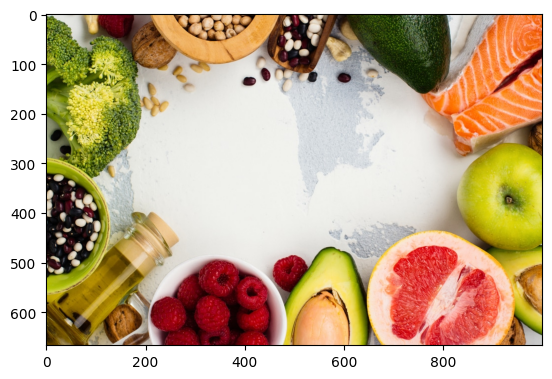

In [41]:
plt.imshow(image)
plt.show()

#Let's pass this image to our model

In [42]:
vision_model = load_model('gemini-pro-vision')

In [43]:
prompt = "You are a helpful assistant. Your task is to understand the image and explain it to user what that image is all about."
message = HumanMessage(
    content =[
        {
          "type":"text",
          "text":prompt
        },
        {
          "type":"image_url",
          "image_url": 'https://miteshmfa.s3.ap-south-1.amazonaws.com/shutterstock_514798843.jpg'
        }

    ]
)

In [45]:
vision_model.invoke([message]).content

'This image is a flat lay photograph showcasing a variety of healthy foods arranged around a central white space.  The foods include:\n\n* **Fruits:**  Raspberries, a grapefruit half, a green apple, and avocado halves.\n* **Vegetables:**  Broccoli.\n* **Proteins:**  Salmon fillets.\n* **Legumes:**  Chickpeas, various types of beans.\n* **Nuts & Seeds:** Walnuts and pine nuts.\n* **Oil:** A small bottle of olive oil.\n\nThe arrangement suggests a healthy eating theme, possibly for a recipe, article, or advertisement promoting nutritious foods. The central empty space could be used for text or a logo.  The overall presentation is vibrant and visually appealing.'

#Build RAG System & Augment the response of the Image

In [46]:
loader = TextLoader("/content/healthy_food.txt")
print(loader.load()[0].page_content)

1. Packed with Nutrients

Fresh vegetables, fruits, nuts, and lean proteins in a salad are rich in vitamins (A, C, K), minerals (potassium, magnesium), and antioxidants.

These help strengthen your immune system, improve skin health, and support overall body functions.

2. High in Fiber

Leafy greens and veggies keep your digestive system running smoothly.

Fiber also helps you feel full longer, reducing overeating.

3. Supports Weight Management

Low-calorie but nutrient-rich, salads can help manage weight without making you feel deprived.

The bulk from vegetables gives satiety without excess carbs or fats.

4. Boosts Hydration

Many salad ingredients (cucumber, lettuce, tomato) have high water content, keeping you hydrated.

5. Good for Heart Health

Using healthy fats (like olive oil, avocado, nuts) in salads can improve cholesterol levels and support heart function.

Antioxidants from colorful veggies help reduce inflammation.

6. Versatile & Customizable

You can tailor a salad f

In [71]:
text = loader.load()[0].page_content

In [72]:
def get_text_chunks_langchain(text):
  text_splitter = CharacterTextSplitter(chunk_size = 20, chunk_overlap=10)
  docs = [Document(page_content=x) for x in text_splitter.split_text(text)]
  return docs

In [54]:
docs = get_text_chunks_langchain(text)

In [73]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [74]:
vectorstore = FAISS.from_documents(docs, embedding=embeddings)

In [75]:
retriever = vectorstore.as_retriever()

In [76]:
retriever.invoke("How can we keep our heart healthy")

[Document(id='5e270286-4e1c-4b77-83de-a361c28ab8b8', metadata={}, page_content='5. Good for Heart Health'),
 Document(id='6aa2cb08-3c85-4c68-a871-bf6887597ea4', metadata={}, page_content='Using healthy fats (like olive oil, avocado, nuts) in salads can improve cholesterol levels and support heart function.'),
 Document(id='98921b0c-964b-4838-a29c-309ac2f54577', metadata={}, page_content='3. Supports Weight Management'),
 Document(id='adf74914-3155-41c8-81e4-29bfa4c175af', metadata={}, page_content='1. Packed with Nutrients')]

In [77]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

In [78]:
llm_vision = load_model("gemini-pro-vision")

In [79]:
llm_text = load_model("gemini-pro")

In [84]:
template = """
'''
{context}
'''

{information}

provide brief information and it's benifit
"""

In [85]:
prompt = ChatPromptTemplate.from_template(template)

# RAG Chain for Multimodel

In [86]:
rag_chain = (
    {"context": retriever, "query": RunnablePassthrough()}
    | prompt
    | llm_text
    | StrOutputParser()
)


In [87]:
result = rag_chain.invoke("What food is good to improve skin and hair ")

In [89]:
display(Markdown(result))

Based on the provided text, **salads** are mentioned as a food that improves skin and hair.

**Brief Information & Benefits:**  The vitamins, healthy fats, and antioxidants in salads nourish skin cells, slow down aging, and promote healthy hair growth.

# Now include Image as well

In [90]:
full_chain = (
    RunnablePassthrough() | llm_vision | StrOutputParser() | rag_chain
)

In [91]:
url="https://miteshmfa.s3.ap-south-1.amazonaws.com/shutterstock_514798843.jpg"

In [92]:
image = get_image(url,'FoodSalad','jpg')

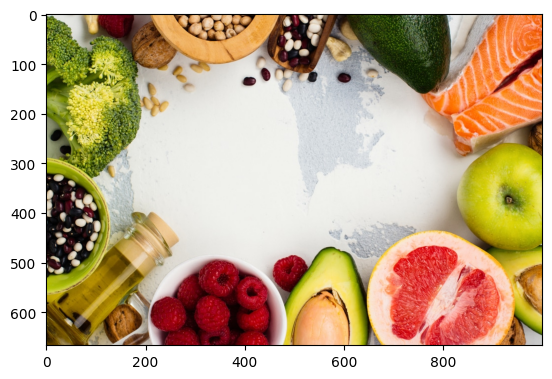

In [93]:
plt.imshow(image)
plt.show()

In [94]:
message = HumanMessage(
    content =[
        {
          "type":"text",
          "text":prompt
        },
        {
          "type":"image_url",
          "image_url": url
        }

    ]
)

In [96]:
result = full_chain.invoke([message])

TypeError: bad argument type for built-in operation